# Visual EDA

The [first page of this chapter](04b-whyplot) discussed the reasons we plot our data. 
1. Data cleaning: To find issues in the data that need to get fixed before we can do larger analysis
2. Data exploration: Learning about each of the variables, how they covary, and what further questions you can ask of the data
3. Analysis and presentation

## EDA on a classic firm financial dataset

In [the Pandas EDA](02e_eda_golden) page, I explored Compustat by producing summary stats to get a sense of the variables involved, look for missing values, and look for problematic outliers. We noted that some variables, like $delaycon$, had a lot of missing values and decided we'd look into it. 

Let's continue exploring that dataset. First, let's download our slice of it. The variables are listed and described in a csv file in the [repo's data folder.](https://github.com/LeDataSciFi/ledatascifi-2021/tree/main/data) 

https://seaborn.pydata.org/generated/seaborn.PairGrid.html#seaborn.PairGrid

https://seaborn.pydata.org/generated/seaborn.PairGrid.map.html#seaborn.PairGrid.map

https://seaborn.pydata.org/generated/seaborn.scatterplot.html#seaborn.scatterplot

In [1]:
from binsreg import binsreg


ModuleNotFoundError: No module named 'binsreg'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# these three are used to download the file
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

url = 'https://github.com/LeDataSciFi/ledatascifi-2021/blob/main/data/CCM_cleaned_for_class.zip?raw=true'

#firms = pd.read_stata(url)   
# <-- that code would work, but GH said it was too big and
# forced me to zip it, so here is the work around to download it:

with urlopen(url) as request:
    data = BytesIO(request.read())

with ZipFile(data) as archive:
    with archive.open(archive.namelist()[0]) as stata:
        ccm = pd.read_stata(stata)


In [ ]:
g = sns.PairGrid(ccm[['capx_a', 'xrd_a', 'cash_a','td_a']])

g.map_lower(binsreg)


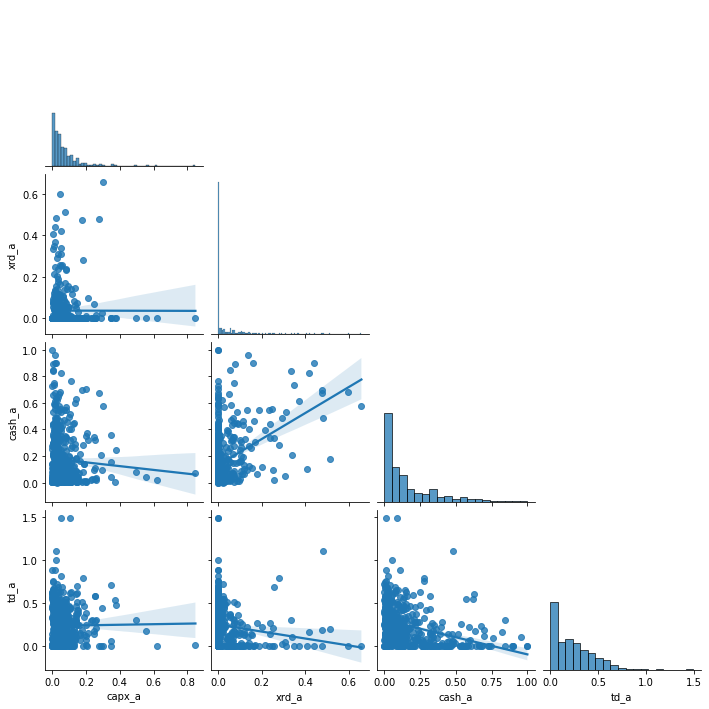

In [2]:


f1 = sns.pairplot(ccm[['capx_a', 'xrd_a', 'cash_a','td_a']].sample(500),
                kind='reg',
                 corner=True)


## Covariances and relationships between variables

To get a quick sense of relationships, I like to use I like to use `pairplot` and `heatmap` to get a quick since of relationships.

### Getting the big picture with [**Pairplot**](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

I like passing `corner=True` or using the `x_vars` and `y_vars` parameters to make the info shown more usable. 

```{warning}
With pairplot, 
1. Use 7 or fewer variables at a time. If your dataset has a lot of variables, do them part by part.
2. Don't plot all of the data points! This will oversaturate your graphs and make it harder to draw any conclusions. Below, I randomly sample a piece of the dataset. 
```

**It's clear from running these two plots that some extreme outliers are hiding patterns by messing with the scales and influencing the regression lines.**

(We should deal with these outliers later.)

In [ ]:
# every time you run this, you'll get diff figures... why?!
f1 = sns.pairplot(ccm[['capx_a', 'xrd_a', 'cash_a','td_a']].sample(500),
                kind='reg',
                 corner=True)
f2 = sns.pairplot(ccm[['capx_a', 'xrd_a', 'cash_a','td_a']].sample(500),
                kind='hist',
                 corner=True) # hist handles a lot of datapoints well


### Getting the big picture with [**Heatmap with correlations**](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

After some pairplots (and often before), I like to look at correlations.

```{warning}
This analysis step doesn't help for categorical variables!

Make sure you don't include categorical variables that are numbers!

(E.g. industry classifications are numbers that have no meaning.)
```

Seeing the correlations between variables is nice.

A correlation table is ugly and hard to work with:


In [ ]:
ccm.corr()

But a lazily made figure of that exact same info is somewhat workable:

In [ ]:
f3 = sns.heatmap(ccm.corr()) # v1, use the nicer version below!

Cleaning that and making it more useful is easy:
1. Drop the numerical variables that don't make sense in a correlation matrix
2. Make the figure large enough to see
3. Colors: cold for negative corr, hot for positive corr

In [ ]:
# dont plot identifying type info or categorical vars
corr = ccm.drop(columns=['gvkey','lpermno','sic3','fyear','sic']).corr()

fig, ax = plt.subplots(figsize=(9,9)) # make a big space for the figure
ax = sns.heatmap(corr,
                 # cmap for the colors, 
                 center=0,square=True,
                 cmap=sns.diverging_palette(230, 20, as_cmap=True),
                 # mask to hide the upper diag (redundant)
                 mask=np.triu(np.ones_like(corr, dtype=bool)),
                 # shrink the heat legend
                 cbar_kws={"shrink": .5},
                 #optional: vmax and vmin will "cap" the color range
                )

That is an information DENSE figure, but we somehow managed to get it on screen decently! Still, it's a ton of variables, and doing this in parts would be a good idea.

```{tip}
If you're feeling frisky, and your data is in good shape, you can push this farther by using [`sns.clustermap`](https://seaborn.pydata.org/generated/seaborn.clustermap.html) to find clusters of similar variables. 
```

Also - don't take these correlations as gospel yet: They should *point* you towards further relationships to explore, which you should do one plot at a time.

### Digging in with [**lmplot**](https://seaborn.pydata.org/generated/seaborn.relplot.html) and [**Jointplot**](https://seaborn.pydata.org/generated/seaborn.jointplot.html)

These are good for digging into the relationships between two continuous variables. 

Let's dig into a strong correlation suggested by our heatmap.

```{warning}

Jointplot can be slow - it's doing a lot. 

Again, don't plot all of the data points! As your sample size goes up, either randomly sample data, or use "hex" style graphs. 
```

In [ ]:
f1 = sns.jointplot(data=ccm.query('xrd_a<.4').sample(1000),
                  x="prodmktfluid", y="xrd_a", kind='reg') 
# notice: most firms have 0 R&D!
f2 = sns.jointplot(data=ccm.query('xrd_a<.4 & xrd_a > 0').sample(1000),
                  x="prodmktfluid", y="xrd_a", kind='reg')

# set_title doesn't work with jointplots
f1.fig.suptitle('Strongly positive, even with zero R&D firms in sample')
f1.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
f2.fig.suptitle('Among R&D firms, even stronger relationship')
f2.fig.subplots_adjust(top=0.95) # Reduce plot to make room 


I'd pencil this as a relationship to look into more (Do firms do more R&D _**because**_ of the fluidity of their product market?) and then continue exploring. 

`lmplot` will plot regressions as well, but it makes it easy add [facets](04d-whichplot) to see if the relationship depends on a third (categorical) variable with the `hue`, `col`, and `row` parameters. (And you can combine `hue`, `col`, and `row` to see several cuts!)

In [ ]:
f3 = sns.lmplot(data=ccm.query('xrd_a<.4 & xrd_a > 0').sample(1000),
                  x="prodmktfluid", y="xrd_a", hue='div_d')
f4 = sns.lmplot(data=ccm.query('xrd_a<.4 & xrd_a > 0').sample(1000),
                  x="prodmktfluid", y="xrd_a", col='div_d')
